# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [1]:
%matplotlib inline

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import pandas
pandas.options.display.max_columns = None


import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.colors
import watershed_workflow.condition
import watershed_workflow.mesh
import watershed_workflow.split_hucs

watershed_workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)


## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [3]:
# specify the input shapefile and a hint as to what HUC it is in.
coweeta_shapefile = 'Coweeta/input_data/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
simplify = 30 # length scale to target average edge

logging.info("")
logging.info("Meshing shape: {}".format(coweeta_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, coweeta = watershed_workflow.get_split_form_shapes(coweeta_shapefile)

2022-02-28 14:55:02,553 - root - INFO: 
2022-02-28 14:55:02,555 - root - INFO: Meshing shape: Coweeta/input_data/coweeta_basin.shp
2022-02-28 14:55:02,556 - root - INFO: ==============================
2022-02-28 14:55:02,557 - root - INFO: 
2022-02-28 14:55:02,557 - root - INFO: Loading shapes
2022-02-28 14:55:02,558 - root - INFO: ------------------------------
2022-02-28 14:55:02,559 - root - INFO: Loading file: 'Coweeta/input_data/coweeta_basin.shp'
2022-02-28 14:55:02,573 - root - INFO: ... found 1 shapes
2022-02-28 14:55:02,574 - root - INFO: Converting to shapely


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [4]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerSoilGrids2017()

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
sources['land cover'] = watershed_workflow.source_list.FileManagerRaster('Coweeta/input_data/land_cover/land_cover.tif')
sources['geologic structure'] = watershed_workflow.source_list.FileManagerGLHYMPS('Coweeta/input_data/GLHYMPS/GLHYMPS.shp')
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerRaster('Coweeta/input_data/DTB/DTB.tif')
watershed_workflow.source_list.log_sources(sources)

2022-02-28 14:55:02,586 - root - INFO: Using sources:
2022-02-28 14:55:02,587 - root - INFO: --------------
2022-02-28 14:55:02,588 - root - INFO: HUC: National Watershed Boundary Dataset (WBD)
2022-02-28 14:55:02,588 - root - INFO: hydrography: National Hydrography Dataset (NHD)
2022-02-28 14:55:02,589 - root - INFO: DEM: National Elevation Dataset (NED)
2022-02-28 14:55:02,589 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2022-02-28 14:55:02,590 - root - INFO: geologic structure: Coweeta/input_data/GLHYMPS/GLHYMPS.shp
2022-02-28 14:55:02,591 - root - INFO: land cover: raster
2022-02-28 14:55:02,592 - root - INFO: soil thickness: None
2022-02-28 14:55:02,592 - root - INFO: meteorology: DayMet 1km
2022-02-28 14:55:02,593 - root - INFO: depth to bedrock: raster


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

In [5]:
# find what HUC our shape is in
huc = watershed_workflow.find_huc(sources['HUC'], coweeta.exterior(), crs, hint, shrink_factor=0.1)
logging.info("Found Coweeta in HUC: {}".format(huc))

2022-02-28 14:55:02,608 - root - INFO: 
2022-02-28 14:55:02,608 - root - INFO: Loading HUC 0601
2022-02-28 14:55:02,609 - root - INFO: ------------------------------
2022-02-28 14:55:02,610 - root - INFO: 
2022-02-28 14:55:02,611 - root - INFO: Loading level 4 HUCs in 0601
2022-02-28 14:55:02,612 - root - INFO: ------------------------------
2022-02-28 14:55:02,614 - root - INFO: Using HUC file "/Users/uec/code/watershed_workflow/data-library/hydrography/WBD_06_GDB/WBD_06.gdb"
2022-02-28 14:55:02,726 - root - INFO: ... found 1 HUCs
2022-02-28 14:55:02,727 - root - INFO:   -- 0601
2022-02-28 14:55:02,728 - root - INFO: Converting to out_crs
2022-02-28 14:55:02,767 - root - INFO: Converting to shapely
2022-02-28 14:55:02,784 - root - INFO: ... found 1
2022-02-28 14:55:02,790 - root - INFO: 
2022-02-28 14:55:02,790 - root - INFO: Loading level 6 HUCs in 0601
2022-02-28 14:55:02,791 - root - INFO: ------------------------------
2022-02-28 14:55:02,793 - root - INFO: Using HUC file "/Users/

In [6]:
rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], huc, 
                                      coweeta.exterior().bounds, crs, crs)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = watershed_workflow.construct_rivers(coweeta, reaches, filter=True, tol=simplify)
    watershed_workflow.simplify(coweeta, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                                snap=True, cut_intersections=True)

else:
    rivers = list()
    watershed_workflow.split_hucs.simplify(coweeta, simplify)



2022-02-28 14:55:03,505 - root - INFO: 
2022-02-28 14:55:03,506 - root - INFO: Loading Hydrography
2022-02-28 14:55:03,507 - root - INFO: ------------------------------
2022-02-28 14:55:03,508 - root - INFO: Loading streams in HUC 060102020103
2022-02-28 14:55:03,508 - root - INFO:          and/or bounds (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2022-02-28 14:55:03,510 - root - INFO:   Using Hydrography file "/Users/uec/code/watershed_workflow/data-library/hydrography/NHD_H_06010202_GDB/NHD_H_06010202.gdb"
2022-02-28 14:55:03,511 - root - INFO:   National Hydrography Dataset (NHD): opening '/Users/uec/code/watershed_workflow/data-library/hydrography/NHD_H_06010202_GDB/NHD_H_06010202.gdb' layer 'NHDFlowline' for streams in '(273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)'
2022-02-28 14:55:03,578 - root - INFO:   Filtering reaches not in-network
2022-02-28 14:55:03,579 - root - INFO: ... found 35 reaches
2022-02-28 14:55

/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_DEV-2021-11-10/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


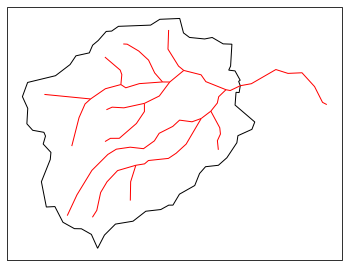

In [7]:
# plot what we have so far -- an image of the HUC and its stream network
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

watershed_workflow.plot.hucs(coweeta, crs, ax=ax, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

2022-02-28 14:55:03,931 - root - INFO: 
2022-02-28 14:55:03,932 - root - INFO: Meshing
2022-02-28 14:55:03,932 - root - INFO: ------------------------------
2022-02-28 14:55:03,943 - root - INFO: Triangulating...
2022-02-28 14:55:03,944 - root - INFO:    62 points and 62 facets
2022-02-28 14:55:03,945 - root - INFO:  checking graph consistency
2022-02-28 14:55:03,946 - root - INFO:  tolerance is set to 1
2022-02-28 14:55:03,947 - root - INFO:  building graph data structures
2022-02-28 14:55:03,949 - root - INFO:  triangle.build...
2022-02-28 14:55:07,796 - root - INFO:   ...built: 8086 mesh points and 15945 triangles
2022-02-28 14:55:07,797 - root - INFO: Plotting triangulation diagnostics
2022-02-28 14:55:08,806 - root - INFO:   min area = 289.77447509765625
2022-02-28 14:55:08,806 - root - INFO:   max area = 4979.40869140625


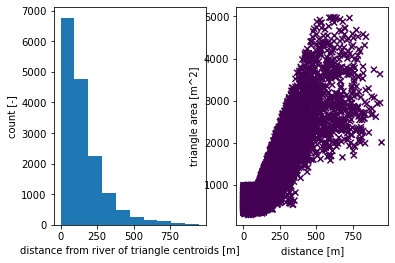

In [8]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500
A0 = 1000; A1 = 5000
#A0 = 500; A1 = 2500
#A0 = 100; A1 = 500

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, dists = watershed_workflow.triangulate(coweeta, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True)
#mesh_points2, mesh_tris, d = watershed_workflow.triangulate(coweeta, rivers,
#                                                 refine_max_area=100000,
#                                                 enforce_delaunay=True,
#                                                 diagnostics=True)

In [9]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], coweeta.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

2022-02-28 14:55:09,120 - root - INFO: 
2022-02-28 14:55:09,121 - root - INFO: Loading Raster
2022-02-28 14:55:09,122 - root - INFO: ------------------------------
2022-02-28 14:55:09,123 - root - INFO: Collecting raster
2022-02-28 14:55:09,127 - root - INFO: Collecting DEMs to tile bounds: [-83.48845037186388, 35.01734099944037, -83.41165773504302, 35.08381933600275]
2022-02-28 14:55:09,128 - root - INFO:   Need:
2022-02-28 14:55:09,129 - root - INFO:     /Users/uec/code/watershed_workflow/data-library/dem/USGS_NED_1as_n36_w084.tif
2022-02-28 14:55:09,129 - root - INFO: source files already exist!
2022-02-28 14:55:09,151 - root - INFO: ... got raster of shape: (239, 276)
2022-02-28 14:55:09,152 - root - INFO: ... got raster bounds: (-83.48845037186388, 35.08381933600275, -83.41178370519467, 35.01743044711165)
2022-02-28 14:55:09,153 - root - INFO: 
2022-02-28 14:55:09,154 - root - INFO: Elevating Triangulation to DEM
2022-02-28 14:55:09,154 - root - INFO: -----------------------------

Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

/Users/Shared/ornldev/code/watershed_workflow/repos/master/watershed_workflow/plot.py:110: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=window)


[Text(3878000.0, 0, ''),
 Text(3879000.0, 0, ''),
 Text(3880000.0, 0, ''),
 Text(3881000.0, 0, ''),
 Text(3882000.0, 0, ''),
 Text(3883000.0, 0, ''),
 Text(3884000.0, 0, ''),
 Text(3885000.0, 0, '')]

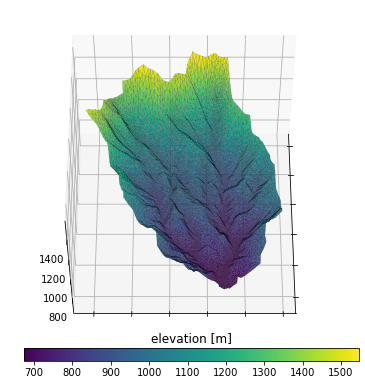

In [10]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = watershed_workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(55,0)
ax.set_xticklabels(list())
ax.set_yticklabels(list())


(273632.49028452876, 281081.70602489595)
(3878085.9481054433, 3884707.4732079916)


Text(0.5, 1.0, 'elevation [m]')

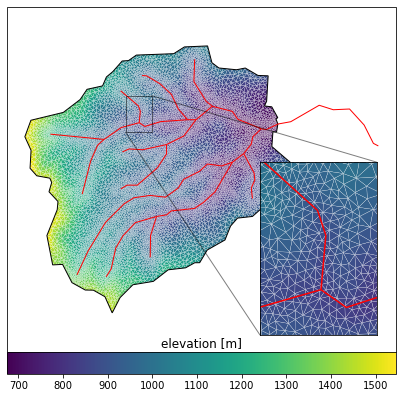

In [11]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = watershed_workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

xlim = (275900., 276400.)
ylim = (3882300., 3883000.)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
watershed_workflow.plot.hucs(coweeta, crs, ax=ax, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')

mp2 = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
watershed_workflow.plot.hucs(coweeta, crs, ax=ax2, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax2, color='red', linewidth=1.5)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')


print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('elevation [m]')


In [12]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

max diff =  6.589355426081738


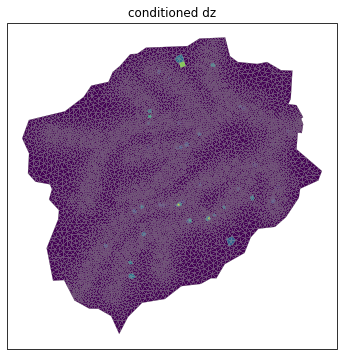

In [13]:
# hydrologically condition the mesh, removing pits
watershed_workflow.condition.fill_pits(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
watershed_workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [14]:
# download the NLCD raster
lc_profile, lc_raster = watershed_workflow.get_raster_on_shape(sources['land cover'], 
                                                     coweeta.exterior(), crs)

# resample the raster to the triangles
lc = watershed_workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2022-02-28 14:55:12,472 - root - INFO: 
2022-02-28 14:55:12,473 - root - INFO: Loading Raster
2022-02-28 14:55:12,474 - root - INFO: ------------------------------
2022-02-28 14:55:12,475 - root - INFO: Collecting raster
2022-02-28 14:55:12,503 - root - INFO: bounds in my_crs: (1129295.2795605154, 1404623.589663599, 1134445.5249579642, 1410000.8473879488)
2022-02-28 14:55:12,505 - root - INFO: ... got raster of shape: (180, 173)
2022-02-28 14:55:12,514 - root - INFO: ... got raster bounds: (1129275.0, 1410015.0, 1134465.0, 1404615.0)
2022-02-28 14:55:12,800 - root - INFO: Found land cover dtypes: uint8
2022-02-28 14:55:12,801 - root - INFO: Found land cover types: {41, 42, 43, 81, 52, 21, 22, 23}


Text(0.5, 1.0, 'land cover index')

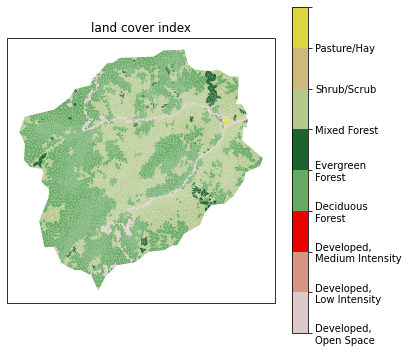

In [15]:
# plot the NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                watershed_workflow.colors.generate_nlcd_colormap(lc)

# this is just hacking the label names to make them display a bit neater for a cleaner plot.  Likely it 
# should get put into the NLCD manager instead of here! See #8
nlcd_labels_fw = []
for label in nlcd_labels:
    label_fw = label
    if len(label) > 15:
        if ' ' in label:
            lsplit = label.split()
            if len(lsplit) == 2:
                label_fw = '\n'.join(lsplit)
            elif len(lsplit) == 4:
                label_fw = '\n'.join([' '.join(lsplit[0:2]),
                                      ' '.join(lsplit[2:])])
            elif len(lsplit) == 3:
                if len(lsplit[0]) > len(lsplit[-1]):
                    label_fw = '\n'.join([lsplit[0],
                                          ' '.join(lsplit[1:])])
                else:
                    label_fw = '\n'.join([' '.join(lsplit[:-1]),
                                          lsplit[-1]])
    nlcd_labels_fw.append(label_fw)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, 
                                     norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
mp = pcm.ScalarMappable(norm=nlcd_norm, cmap=nlcd_cmap)
cb = fig.colorbar(mp)
cb.set_ticks(nlcd_ticks)
cb.set_ticklabels(nlcd_labels_fw)
ax.set_title("land cover index")

## Subsurface properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

### SSURGO Soil Properties

In [21]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
soil_profile, soil_survey, soil_survey_props = \
        watershed_workflow.get_shapes(sources['soil structure'], [coweeta.exterior(),],
                                      crs, crs, properties=True)


# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array(soil_survey_props['mukey'][:], np.int32)
    
# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = watershed_workflow.color_raster_from_shapes(coweeta.exterior().bounds, 
                                                                                    10, soil_survey, soil_ids, crs, -1)

# -- resample the raster to the triangles
soil_color = watershed_workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)


2022-02-28 15:01:11,144 - root - INFO: 
2022-02-28 15:01:11,145 - root - INFO: Loading shapes
2022-02-28 15:01:11,146 - root - INFO: ------------------------------
2022-02-28 15:01:11,182 - root - INFO: Attempting to download source for target '/Users/uec/code/watershed_workflow/data-library/soil_structure/SSURGO/SSURGO_-83.4790_35.0269_-83.4208_35.0743.shp'
2022-02-28 15:01:11,200 - root - INFO:   Found 490 shapes.
2022-02-28 15:01:11,202 - root - INFO:   and crs: epsg:4326
2022-02-28 15:01:11,203 - root - INFO:   Downloaded 490 total shapes
2022-02-28 15:01:11,204 - root - INFO:   Downloaded 43 unique mukeys
2022-02-28 15:01:11,376 - root - INFO: found 43 unique MUKEYs.
2022-02-28 15:01:13,169 - root - INFO: Running Rosetta for van Genutchen parameters
2022-02-28 15:01:13,330 - root - INFO:   ... done
2022-02-28 15:01:13,333 - root - INFO:   requested 43 values
2022-02-28 15:01:13,334 - root - INFO:   got 43 responses
2022-02-28 15:01:13,343 - root - INFO: ... found 43 shapes
2022-02

In [22]:
soil_survey_props

,residual saturation [-],Rosetta porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],Rosetta permeability [m^2],mukey,thickness [cm],permeability [m^2],porosity [-],bulk density [g/cm^3],total sand pct [%],total silt pct [%],total clay pct [%],source
0,0.177165,0.431041,0.000139,1.470755,8.079687e-13,545800,203.0,3.429028e-15,0.307246,1.297356,66.356250,19.518750,14.125000,NRCS
1,0.177493,0.432741,0.000139,1.469513,8.184952e-13,545801,203.0,3.247236e-15,0.303714,1.292308,66.400000,19.300000,14.300000,NRCS
2,0.172412,0.400889,0.000150,1.491087,6.477202e-13,545803,203.0,2.800000e-12,0.379163,1.400000,66.799507,21.700493,11.500000,NRCS
3,0.177122,0.388687,0.000083,1.468789,3.412748e-13,545805,203.0,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS
4,0.177122,0.388687,0.000083,1.468789,3.412748e-13,545806,203.0,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS
5,0.177122,0.388687,0.000083,1.468789,3.412748e-13,545807,203.0,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS
6,0.185732,0.387543,0.000162,1.466606,4.631920e-13,545811,203.0,1.196738e-12,0.330802,1.484203,68.011736,18.128229,13.860034,NRCS
7,0.185732,0.387543,0.000162,1.466606,4.631920e-13,545812,203.0,1.196738e-12,0.330802,1.484203,68.011736,18.128229,13.860034,NRCS
8,0.183468,0.398767,0.000127,1.445858,4.296896e-13,545813,203.0,6.219065e-14,0.349442,1.410667,60.007287,26.226047,13.766667,NRCS
9,0.183709,0.398135,0.000126,1.444985,4.224967e-13,545814,203.0,5.999907e-14,0.344322,1.412931,59.790685,26.427142,13.782173,NRCS


/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_DEV-2021-11-10/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


(273712.5998, 279399.40619999997, 3878583.92855, 3884209.4924500003)

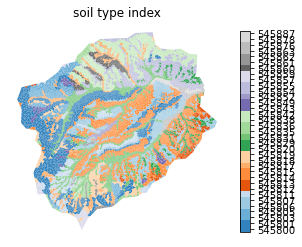

In [23]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = \
        watershed_workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels=labels) 

ax.set_title('soil type index')
ax.axis('off')


Index(['residual saturation [-]', 'Rosetta porosity [-]',
       'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]',
       'Rosetta permeability [m^2]', 'mukey', 'thickness [cm]',
       'permeability [m^2]', 'porosity [-]', 'bulk density [g/cm^3]',
       'total sand pct [%]', 'total silt pct [%]', 'total clay pct [%]',
       'source'],
      dtype='object')
min, max =  0.0 5.432309224866e-312


(273712.5998, 279399.40619999997, 3878583.92855, 3884209.4924500003)

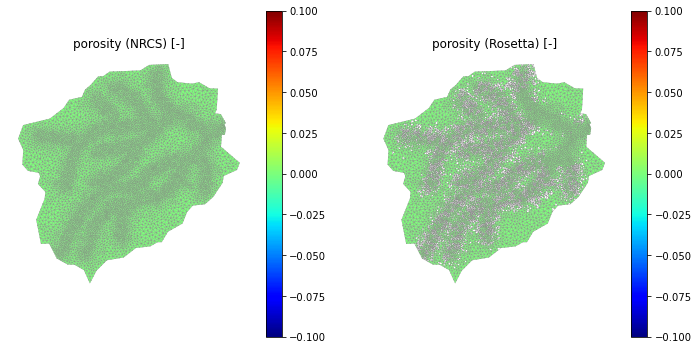

In [24]:
# Note this is not just the soil ID, but also soil properties.  
print(soil_survey_props.keys())

# To demonstrate what we mean by this, plot the porosity of the soil column.
porosity_nrcs = np.empty(soil_color.shape, 'd')
porosity_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    porosity_nrcs[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']
    porosity_rosetta[soil_color == mukey] = soil_survey_props.loc[ mukey,'Rosetta porosity [-]']

pmin = min(np.nanmin(porosity_nrcs), np.nanmin(porosity_rosetta))
pmax = max(np.nanmax(porosity_nrcs), np.nanmax(porosity_rosetta))
print('min, max = ', pmin, pmax)


fig = plt.figure(figsize=(12,6))
ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=porosity_nrcs, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('porosity (NRCS) [-]')
ax1.axis('off')


ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=porosity_rosetta, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('porosity (Rosetta) [-]')
ax2.axis('off')


min = -14.488486163789586, max = -11.204180480714642


Text(0.5, 1.0, 'log permeability (Rosetta) [m^2]')

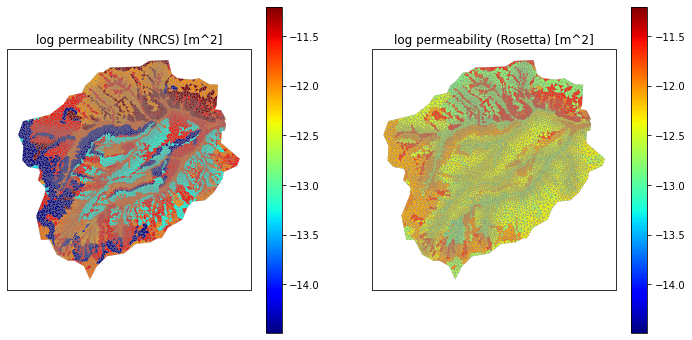

In [25]:
# averaging permeability is a tricky beast.  we average in log space, check that 
# unit conversions make sense
fig = plt.figure(figsize=(12,6))
soil_perm_nrcs = np.empty(soil_color.shape, 'd')
soil_perm_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props['mukey']:
    soil_perm_nrcs[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey'] == mukey, 
                                                                'permeability [m^2]']
    soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey'] == mukey, 
                                                                   'Rosetta permeability [m^2]']

pmin = min(np.log10(soil_perm_nrcs).min(), np.log10(soil_perm_rosetta).min())
pmax = max(np.log10(soil_perm_nrcs).max(), np.log10(soil_perm_rosetta).max())

  
print(f'min = {pmin}, max = {pmax}')

ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=np.log10(soil_perm_nrcs), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('log permeability (NRCS) [m^2]')

ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=np.log10(soil_perm_rosetta), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('log permeability (Rosetta) [m^2]')




[203. 203. 203. ... 203. 203. 203.]
Median soil thickness [-] =  2.03


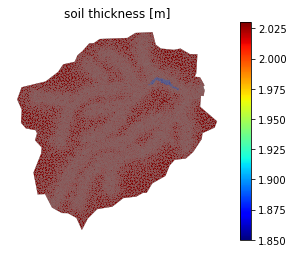

In [26]:
# finally, let's look at the soil thickness, which will define the depth of this layer
soil_thickness = np.zeros(soil_color.shape, 'd')
for mukey in soil_survey_props['mukey']:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey'] == mukey,
                                                                'thickness [cm]']

print(soil_thickness)
soil_thickness = soil_thickness / 100
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=soil_thickness, edgecolor='gray', cmap='jet')
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print('Median soil thickness [-] = ', np.nanmedian(soil_thickness))

### GLYHMPS geologic layer

In [27]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = coweeta.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = \
    watershed_workflow.get_shapes(sources['geologic structure'], target_bounds, 
                                  crs, crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            watershed_workflow.color_raster_from_shapes(target_bounds, 10, geo_survey,
                                              geo_ids, crs)

# -- resample the raster to the triangles
geo_color = watershed_workflow.values_from_raster(m2.centroids(), crs, 
                                         geo_color_raster, geo_color_profile)


2022-02-28 15:01:30,385 - root - INFO: target bounds: (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2022-02-28 15:01:30,386 - root - INFO: 
2022-02-28 15:01:30,387 - root - INFO: Loading shapes
2022-02-28 15:01:30,388 - root - INFO: ------------------------------
2022-02-28 15:01:30,389 - root - INFO: Getting shapes of GLHYMPS on bounds: (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2022-02-28 15:01:30,440 - root - INFO: ... found 1 shapes
2022-02-28 15:01:30,441 - root - INFO: Converting to shapely
2022-02-28 15:01:30,447 - root - INFO: Converting to requested CRS
2022-02-28 15:01:30,468 - root - INFO: shape union bounds: (159518.27011641115, 3816621.6554112737, 431027.3363569959, 4024643.4346461874)
2022-02-28 15:01:30,469 - root - INFO: Coloring shapes onto raster:
2022-02-28 15:01:30,470 - root - INFO:   target_bounds = (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2022-02-28 15:01:30

,id,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-]
0,1793338,GLHYMPS,3.019952e-11,1.61,0.01,0.023953,2.0,0.01


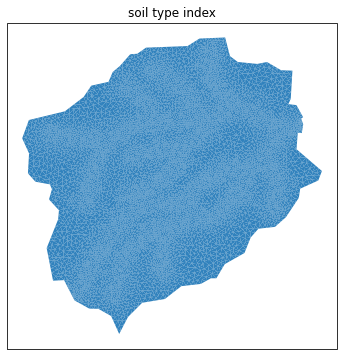

In [28]:
# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, cmap='tab20c')
ax.set_title('soil type index')
geo_survey_props



## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [29]:
DTB_profile, DTB_raster = watershed_workflow.get_raster_on_shape(sources['depth to bedrock'], 
                                                                 coweeta.exterior(), crs, 
                                                                 nodata=-99999)
                                        #, variable='BDTICM') # note, this argument needed for 
                                        # using the default SoilGrids dataset.

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = watershed_workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)

2022-02-28 15:01:38,439 - root - INFO: 
2022-02-28 15:01:38,440 - root - INFO: Loading Raster
2022-02-28 15:01:38,441 - root - INFO: ------------------------------
2022-02-28 15:01:38,442 - root - INFO: Collecting raster
2022-02-28 15:01:38,457 - root - INFO: bounds in my_crs: (-83.47845037186387, 35.02734099944037, -83.42165773504303, 35.07381933600275)
2022-02-28 15:01:38,459 - root - INFO: ... got raster of shape: (23, 28)
2022-02-28 15:01:38,460 - root - INFO: ... got raster bounds: (-83.47918210999998, 35.074175034, -83.42084878599998, 35.026258375)


/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_DEV-2021-11-10/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


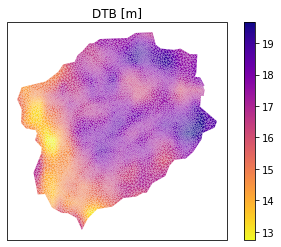

In [30]:
# plot the resulting surface mesh
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp)
title = ax.set_title('DTB [m]')


## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs
* 1000-9999 : soil layer material IDs




In [31]:
soil_survey_props['ats_id'] = range(1000, 1000+len(soil_survey_props))
soil_survey_props.set_index('ats_id', inplace=True)

geo_survey_props['ats_id'] = range(100, 100+len(geo_survey_props))
geo_survey_props.set_index('ats_id', inplace=True)

subsurface_props = pandas.concat([geo_survey_props,soil_survey_props])

In [32]:
# must choose properties for geologic media.  Here we choose one that has a similar porosity
subsurface_props.loc[100, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] =  \
      subsurface_props.loc[1024, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] 

# save the properties to disk for use in generating input file
subsurface_props.to_csv(os.path.join('Coweeta', 'output_data', 'coweeta_subsurface_properties.csv'))



Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [33]:
# Generate a dz structure for the top 2m of soil -- it appears from above that the soil thickness is uniformly 2m
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)

[0.0500016  0.05030145 0.06625834 0.1110568  0.22600204 0.49640501
 0.49997989 0.49999487]


In [34]:
# this looks like it would work out:
dzs = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs))

2.0


In [35]:
# a 2m soil thickness and a maximum of 20m depth to bedrock suggests a
# geologic layer of 18 - 1m cells
dzs = dzs + [1.0,]*18

In [36]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- add the layers
depth = 0
for dz in dzs:
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    # to set the layer type, we check whether it is
    #   * above the soil thickness (it is soil)
    #   * below the depth to bedrock (it is bedrock)
    #   * else it is geologic layer
    # -- set the depth as the cell midpoint
    depth += 0.5 * dz
    
    # -- bedrock (999) or geologic layer (from geo_color)
    br_or_geo = np.where(depth < DTB, geo_color, 999)
    
    # -- are we in the soil horizons?
    mat_id = np.where(np.bitwise_and(soil_color > 0, depth < soil_thickness),
                      soil_color, br_or_geo)

    depth += 0.5 * dz
    layer_mat_ids.append(mat_id)
    
# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2022-02-28 15:01:46,143 - root - INFO: Cell summary:
2022-02-28 15:01:46,143 - root - INFO: ------------------------------------------------------------
2022-02-28 15:01:46,144 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2022-02-28 15:01:46,146 - root - INFO: ------------------------------------------------------------
2022-02-28 15:01:46,147 - root - INFO:  00 	| 00 	| 545887 	|   0.050000 	|   0.000000
2022-02-28 15:01:46,147 - root - INFO:  01 	| 01 	| 545887 	|   0.050000 	|   0.050000
2022-02-28 15:01:46,148 - root - INFO:  02 	| 02 	| 545887 	|   0.050000 	|   0.100000
2022-02-28 15:01:46,149 - root - INFO:  03 	| 03 	| 545887 	|   0.120000 	|   0.150000
2022-02-28 15:01:46,150 - root - INFO:  04 	| 04 	| 545887 	|   0.230000 	|   0.270000
2022-02-28 15:01:46,151 - root - INFO:  05 	| 05 	| 545887 	|   0.500000 	|   0.500000
2022-02-28 15:01:46,152 - root - INFO:  06 	| 06 	| 545887 	|   0.500000 	|   1.000000
2022-02-28 15:01:46,153 - root - INFO:  07 	| 07 	| 545887 	|   0

In [37]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [38]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = watershed_workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [39]:
# save to disk
try:
    os.remove(os.path.join('Coweeta', 'output_data', 'coweeta_basin.exo'))
except FileNotFoundError:
    pass
m3.write_exodus(os.path.join('Coweeta', 'output_data', 'coweeta_basin.exo'))


You are using exodus.py v 1.20.10 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: Coweeta/output_data/coweeta_basin.exo


2022-02-28 15:02:00,627 - root - INFO: adding side set: 1
2022-02-28 15:02:00,678 - root - INFO: adding side set: 2
2022-02-28 15:02:00,733 - root - INFO: adding side set: 3
2022-02-28 15:02:00,775 - root - INFO: adding side set: 21
2022-02-28 15:02:00,815 - root - INFO: adding side set: 22
2022-02-28 15:02:00,854 - root - INFO: adding side set: 23
2022-02-28 15:02:00,891 - root - INFO: adding side set: 41
2022-02-28 15:02:00,938 - root - INFO: adding side set: 42
2022-02-28 15:02:00,975 - root - INFO: adding side set: 43
2022-02-28 15:02:01,020 - root - INFO: adding side set: 52
2022-02-28 15:02:01,057 - root - INFO: adding side set: 81


Closing exodus file: Coweeta/output_data/coweeta_basin.exo
